<a href="https://colab.research.google.com/github/spour/DeepExplain/blob/master/shap_explain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install git+https://github.com/slundberg/shap

In [2]:
%matplotlib inline
from __future__ import print_function, division

In [3]:
! [[ ! -f sequences.simdata.gz ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
! [[ ! -f keras2_conv1d_record_5_model_PQzyq_modelJson.json ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/b6e1d69/deeplift/genomics/keras2_conv1d_record_5_model_PQzyq_modelJson.json
! [[ ! -f keras2_conv1d_record_5_model_PQzyq_modelWeights.h5 ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/b6e1d69/deeplift/genomics/keras2_conv1d_record_5_model_PQzyq_modelWeights.h5
! [[ ! -f test.txt.gz ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/9aadb769735c60eb90f7d3d896632ac749a1bdd2/deeplift/genomics/test.txt.gz


In [4]:
! pip install simdna

In [5]:
import simdna.synthetic as synthetic
import gzip
data_filename = "sequences.simdata.gz"

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = [x.decode("utf-8").rstrip("\n") for x in test_ids_fh]
data = synthetic.read_simdata_file(data_filename, ids_to_load=ids_to_load)

In [6]:
import numpy as np

#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels)
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
onehot_data = np.array([one_hot_encode_along_channel_axis(seq) for seq in data.sequences])

In [7]:
from tensorflow.keras.models import model_from_json

#load the keras model
keras_model_weights = "keras2_conv1d_record_5_model_PQzyq_modelWeights.h5"
keras_model_json = "keras2_conv1d_record_5_model_PQzyq_modelJson.json"

keras_model = model_from_json(open(keras_model_json).read())
keras_model.load_weights(keras_model_weights)

In [8]:
!pip install deeplift

In [ ]:
# !pip install tensorflow==2.5.0
# import tensorflow

In [10]:
from collections import defaultdict
from random import shuffle


# compile the dinucleotide edges
def prepare_edges(s):
    edges = defaultdict(list)
    for i in range(len(s) - 1):
        edges[tuple(s[i])].append(s[i + 1])
    return edges


def shuffle_edges(edges):
    # for each character, remove the last edge, shuffle, add edge back
    for char in edges:
        last_edge = edges[char][-1]
        edges[char] = edges[char][:-1]
        the_list = edges[char]
        shuffle(the_list)
        edges[char].append(last_edge)
    return edges


def traverse_edges(s, edges):
    generated = [s[0]]
    edges_queue_pointers = defaultdict(lambda: 0)
    for i in range(len(s) - 1):
        last_char = generated[-1]
        generated.append(edges[tuple(last_char)][edges_queue_pointers[tuple(last_char)]])
        edges_queue_pointers[tuple(last_char)] += 1
    if isinstance(generated[0], str):
        return "".join(generated)
    else:
        import numpy as np
        return np.asarray(generated)


def dinuc_shuffle(s):
    if isinstance(s, str):
        s = s.upper()
    return traverse_edges(s, shuffle_edges(prepare_edges(s)))


def onehot_dinuc_shuffle(s): 
    s = np.squeeze(s)
    argmax_vals = "".join([str(x) for x in np.argmax(s, axis=-1)])
    shuffled_argmax_vals = [int(x) for x in traverse_edges(argmax_vals,                          
                            shuffle_edges(prepare_edges(argmax_vals)))]    
    to_return = np.zeros_like(s)    
    to_return[list(range(len(s))), shuffled_argmax_vals] = 1    
    return to_return

shuffle_several_times = lambda s: np.array([onehot_dinuc_shuffle(s) for i in range(100)])

In [11]:

from collections import Counter

def onehot_dinuc_shuffle(s): 
    s = np.squeeze(s)
    argmax_vals = "".join([str(x) for x in np.argmax(s, axis=-1)])
    shuffled_argmax_vals = [int(x) for x in traverse_edges(argmax_vals,                          
                            shuffle_edges(prepare_edges(argmax_vals)))]    
    to_return = np.zeros_like(s)    
    to_return[list(range(len(s))), shuffled_argmax_vals] = 1    
    return to_return

shuffle_several_times = lambda s: np.array([onehot_dinuc_shuffle(s) for i in range(100)])

In [12]:
seqs_to_explain = onehot_data[[0,3,9]]
print(seqs_to_explain.shape)
shuffle_several_times(seqs_to_explain[0]).shape
!pip install shap

(3, 200, 4)


# MY MODEL



In [38]:
! [[ ! -f sequences.simdata.gz ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
! [[ ! -f keras2_conv1d_record_5_model_PQzyq_modelJson.json ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/b6e1d69/deeplift/genomics/keras2_conv1d_record_5_model_PQzyq_modelJson.json
! [[ ! -f keras2_conv1d_record_5_model_PQzyq_modelWeights.h5 ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/b6e1d69/deeplift/genomics/keras2_conv1d_record_5_model_PQzyq_modelWeights.h5
! [[ ! -f test.txt.gz ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/9aadb769735c60eb90f7d3d896632ac749a1bdd2/deeplift/genomics/test.txt.gz

import simdna.synthetic as synthetic
import gzip
data_filename = "sequences.simdata.gz"

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = [x.decode("utf-8").rstrip("\n") for x in test_ids_fh]
data = synthetic.read_simdata_file(data_filename, ids_to_load=ids_to_load)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data.sequences, data.labels)
print(data.sequences[1])
len(data.sequences[0])
data.labels

import numpy as np

#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels)
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
onehot_data = np.array([one_hot_encode_along_channel_axis(seq) for seq in x_train])

onehot_data.shape
print(input_shape)
print(onehot_data.shape)

from tensorflow.keras.layers import Conv1D, MaxPooling1D
one_filter_keras_model=tensorflow.keras.Sequential() 
conv_layer = Conv1D(filters=1,kernel_size=(10),padding="same",input_shape=onehot_data.shape[1::])
one_filter_keras_model.add(conv_layer)
one_filter_keras_model.add(BatchNormalization(axis=-1))
one_filter_keras_model.add(Activation('relu'))
one_filter_keras_model.add(MaxPooling1D(pool_size=(35)))
one_filter_keras_model.add(Flatten())
one_filter_keras_model.add(Dense(3)) #there are three classes therefore 3 possibilities
one_filter_keras_model.add(Activation("sigmoid"))

one_filter_keras_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=[tensorflow.keras.metrics.CategoricalAccuracy(), 
                                        tensorflow.keras.metrics.AUC(curve='ROC'),
                                        tensorflow.keras.metrics.AUC(curve='PR')])

history_one_filter=one_filter_keras_model.fit(x=onehot_data,
                                  y=y_train,
                                  batch_size=128,
                                  epochs=40, 
                                  verbose=1, 
                                  validation_split=0.2)


TGACAATGGACCCGGTCCGGGTTAGGTACTGATTAGGAACGACCCAGGCCGAGCGACTTATCCCGTTAGATGACGGAATCGTTGTTAGCGGAAAAGAGATAAGAACTTCCCAATTTATACAGATAAGCACACAATGTTTAACGTTCCCGTCTGAGTACTCCTGAATGGGAAGGATATTCTATACTAAGGGATTAGTCGTG
(28, 28, 1)
(600, 200, 4)
Train on 480 samples, validate on 120 samples
Epoch 1/40
128/480 [=======>......................] - ETA: 0s - loss: 2.2569 - categorical_accuracy: 0.5234 - auc_6: 0.4050 - auc_7: 0.3600

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


480/480 [==============================] - 0s 937us/sample - loss: 2.2676 - categorical_accuracy: 0.5083 - auc_6: 0.4115 - auc_7: 0.3693 - val_loss: 1.7740 - val_categorical_accuracy: 0.5250 - val_auc_6: 0.3996 - val_auc_7: 0.4432
Epoch 2/40
480/480 [==============================] - 0s 156us/sample - loss: 2.2037 - categorical_accuracy: 0.5167 - auc_6: 0.4148 - auc_7: 0.3723 - val_loss: 1.7691 - val_categorical_accuracy: 0.5083 - val_auc_6: 0.4029 - val_auc_7: 0.4445
Epoch 3/40
480/480 [==============================] - 0s 127us/sample - loss: 2.1433 - categorical_accuracy: 0.5042 - auc_6: 0.4183 - auc_7: 0.3754 - val_loss: 1.7642 - val_categorical_accuracy: 0.5000 - val_auc_6: 0.4057 - val_auc_7: 0.4469
Epoch 4/40
480/480 [==============================] - 0s 140us/sample - loss: 2.0881 - categorical_accuracy: 0.4979 - auc_6: 0.4231 - auc_7: 0.3800 - val_loss: 1.7596 - val_categorical_accuracy: 0.4667 - val_auc_6: 0.4095 - val_auc_7: 0.4483
Epoch 5/40
480/480 [=======================

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


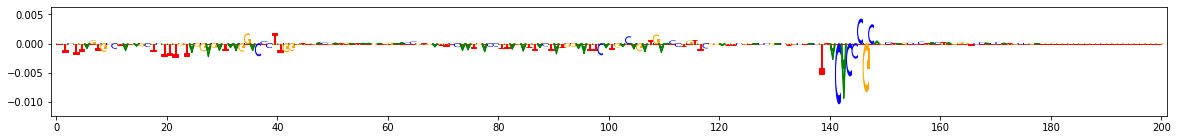

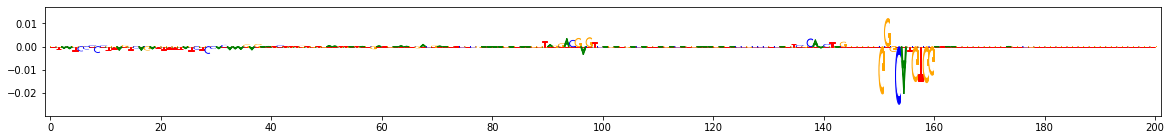

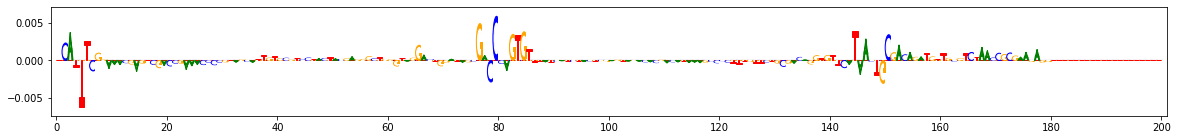

In [41]:
from deeplift.visualization import viz_sequence
import shap
# import shap.explainers.deep.deep_tf
# reload(shap.explainers.deep.deep_tf)
# reload(shap.explainers.deep)
# reload(shap.explainers)
# reload(shap)
import numpy as np
np.random.seed(1)
import random
import tensorflow.keras as keras

# seqs_to_explain = onehot_data[[0,3,9]] #these three are positive for task 0
# dinuc_shuff_explainer = shap.DeepExplainer(one_filter_keras_model, seqs_to_explain)
# raw_shap_explanations = dinuc_shuff_explainer.shap_values(seqs_to_explain)

seqs_to_explain = np.array([one_hot_encode_along_channel_axis(seq) for seq in x_test])[[0,1,2]]
dinuc_shuff_explainer = shap.DeepExplainer((one_filter_keras_model.input, one_filter_keras_model.output[:,0]), shuffle_several_times)
raw_shap_explanations = dinuc_shuff_explainer.shap_values(seqs_to_explain, check_additivity=False)
#project the importance at each position onto the base that's actually present

# for dinuc_shuff_explanation in dinuc_shuff_explanations:
#     viz_sequence.plot_weights(dinuc_shuff_explanation, subticks_frequency=20)
dinuc_shuff_explanations = np.sum(raw_shap_explanations,axis=-1)[:,:,None]*seqs_to_explain
for dinuc_shuff_explanation in dinuc_shuff_explanations:
    viz_sequence.plot_weights(dinuc_shuff_explanation, subticks_frequency=20)

OTHER MODEL


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


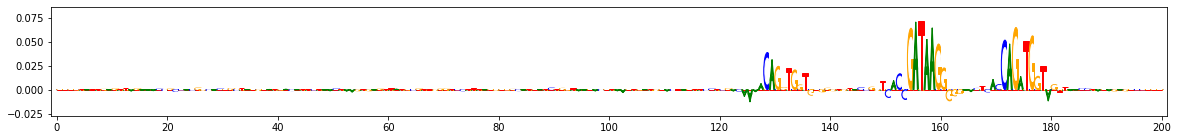

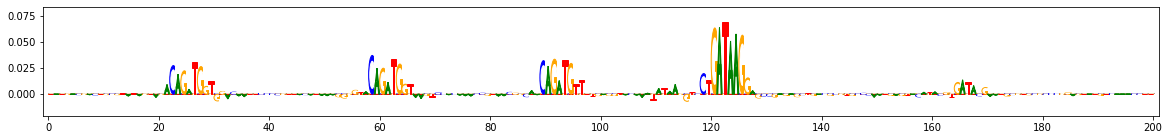

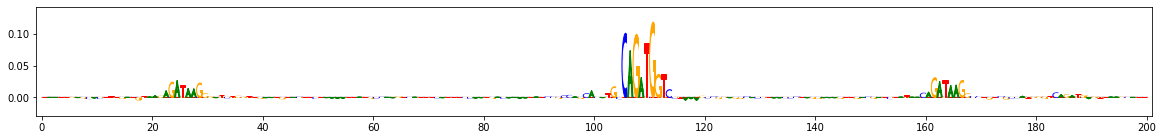

In [57]:
! [[ ! -f sequences.simdata.gz ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
! [[ ! -f keras2_conv1d_record_5_model_PQzyq_modelJson.json ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/b6e1d69/deeplift/genomics/keras2_conv1d_record_5_model_PQzyq_modelJson.json
! [[ ! -f keras2_conv1d_record_5_model_PQzyq_modelWeights.h5 ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/b6e1d69/deeplift/genomics/keras2_conv1d_record_5_model_PQzyq_modelWeights.h5
! [[ ! -f test.txt.gz ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/9aadb769735c60eb90f7d3d896632ac749a1bdd2/deeplift/genomics/test.txt.gz

import simdna.synthetic as synthetic
import gzip
data_filename = "sequences.simdata.gz"

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = [x.decode("utf-8").rstrip("\n") for x in test_ids_fh]
data = synthetic.read_simdata_file(data_filename, ids_to_load=ids_to_load)

import numpy as np

#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels)
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
onehot_data = np.array([one_hot_encode_along_channel_axis(seq) for seq in data.sequences])

from tensorflow.keras.models import model_from_json

#load the keras model
keras_model_weights = "keras2_conv1d_record_5_model_PQzyq_modelWeights.h5"
keras_model_json = "keras2_conv1d_record_5_model_PQzyq_modelJson.json"

keras_model = model_from_json(open(keras_model_json).read())
keras_model.load_weights(keras_model_weights)

# from deeplift.dinuc_shuffle import dinuc_shuffle, traverse_edges, shuffle_edges, prepare_edges
from collections import Counter

def onehot_dinuc_shuffle(s): 
    s = np.squeeze(s)
    argmax_vals = "".join([str(x) for x in np.argmax(s, axis=-1)])
    shuffled_argmax_vals = [int(x) for x in traverse_edges(argmax_vals,                          
                            shuffle_edges(prepare_edges(argmax_vals)))]    
    to_return = np.zeros_like(s)    
    to_return[list(range(len(s))), shuffled_argmax_vals] = 1    
    return to_return

shuffle_several_times = lambda s: np.array([onehot_dinuc_shuffle(s) for i in range(100)])

from deeplift.visualization import viz_sequence
import shap
# import shap.explainers.deep.deep_tf
# reload(shap.explainers.deep.deep_tf)
# reload(shap.explainers.deep)
# reload(shap.explainers)
# reload(shap)
import numpy as np
np.random.seed(1)
import random

# seqs_to_explain = np.array([one_hot_encode_along_channel_axis(seq) for seq in x_test])[[0,3,9]] OR THE BELOW
# seqs_to_explain = onehot_data[[0,3,9]]
# dinuc_shuff_explainer = shap.DeepExplainer((one_filter_keras_model.input, one_filter_keras_model.output[:,0]), shuffle_several_times)
# raw_shap_explanations = dinuc_shuff_explainer.shap_values(seqs_to_explain, check_additivity=False)
# #project the importance at each position onto the base that's actually present

# # for dinuc_shuff_explanation in dinuc_shuff_explanations:
# #     viz_sequence.plot_weights(dinuc_shuff_explanation, subticks_frequency=20)
# dinuc_shuff_explanations = np.sum(raw_shap_explanations,axis=-1)[:,:,None]*seqs_to_explain
# for dinuc_shuff_explanation in dinuc_shuff_explanations:
#     viz_sequence.plot_weights(dinuc_shuff_explanation, subticks_frequency=20)

######or this####
seqs_to_explain = onehot_data[[0,3,9]] #these three are positive for task 0
dinuc_shuff_explainer = shap.DeepExplainer((keras_model.input, keras_model.output[:,0]), shuffle_several_times)
raw_shap_explanations = dinuc_shuff_explainer.shap_values(seqs_to_explain, check_additivity=False)

#project the importance at each position onto the base that's actually present
dinuc_shuff_explanations = np.sum(raw_shap_explanations,axis=-1)[:,:,None]*seqs_to_explain
for dinuc_shuff_explanation in dinuc_shuff_explanations:
    viz_sequence.plot_weights(dinuc_shuff_explanation, subticks_frequency=20)

In [47]:
len(data.sequences)
!pip list
print(d)
# from google.colab import drive
# drive.mount('/content/gdrive')

# with open('/content/gdrive/My Drive/SHAP_EXPLAIN', 'w') as f:
#   f.write(d)

Package                       Version
----------------------------- -------------------
absl-py                       0.12.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.1.0
appdirs                       1.4.4
argcomplete                   1.12.3
argon2-cffi                   20.1.0
arviz                         0.11.2
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.2.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.0.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.2
branca                        0.4.2
bs4                           0.0.1
CacheCo

# TESTING FROM KERAS


In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train, y_train, x_test, y_test= x_train[:100,:,:], y_train[:100], x_test[:100,:,:], y_test[:100]

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

batch_size = 128
epochs = 3

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)


In [21]:
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]
background.shape


(100, 28, 28, 1)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


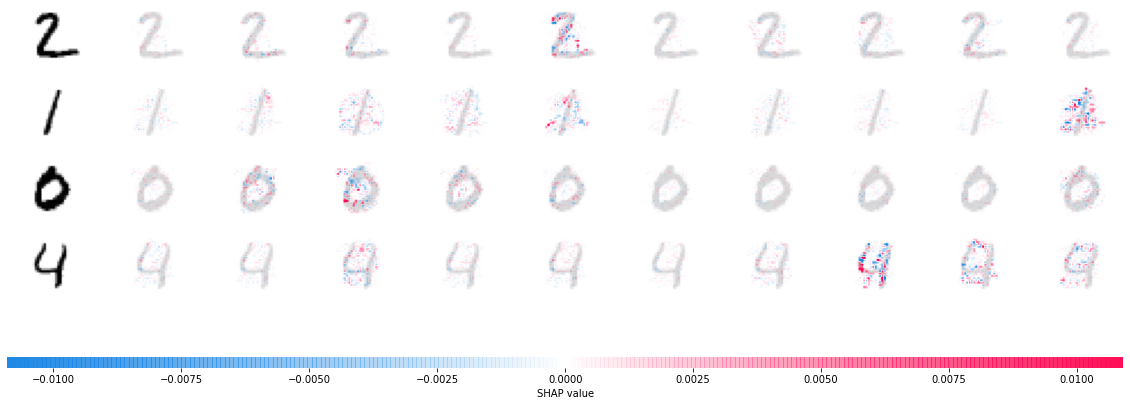

In [20]:
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test[1:5])

# plot the feature attributions
shap.image_plot(shap_values, -x_test[1:5])